In [75]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import os

import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, roc_auc_score

# A ) 
Here we will load the dataset, then split it into train, validation and test data. 
As the Credit Card data is biased, we also create a downzised dataset.

In [76]:
# Reading in credit card dataset.
x,y = ld.load_data(scaler='minmax')

# Splitting data in train and test data
xtrain,xtest,ytrain,ytest = train_test_split(x,y, test_size=0.20, random_state= 0, shuffle=True, stratify=y)

# Splitting in train and validation
#xtrain,xval,ytrain,yval = train_test_split(xtrain,ytrain, test_size=0.25, random_state= 0, shuffle=True, stratify=ytrain)

In [77]:
# Justerer traningsdata 
print(np.sum(ytrain)/len(ytrain))


0.22120833333333334


In [78]:
# Extracting all datapoints where the output is 1 (i.e paying credit card dept).
indices = np.where(ytrain == 1)
indices_zero = np.where(ytrain == 0)
# Randomly extracting equal amount of datapoints where the output is 0 (i.e defaulting).
datapoints = np.random.choice(indices_zero[0], size=ytrain[indices[0]].shape[0], replace=False)

#Stacking the two datasets
x_new = np.vstack((xtrain[indices[0],:],xtrain[datapoints,:]))
y_new = np.vstack((ytrain[indices[0]],ytrain[datapoints]))

# Renaming data
xtrain = x_new
ytrain = y_new

# Extracting some useful shapes.
nx_train, ny_train = xtrain.shape
nx_test, ny_test = xtest.shape

# her er en diskusjon på sin plass.. 

In [79]:
print(nx_train)
print(nx_test)

10618
6000


# B) 
Egen logistic regression med gradient descent.


In [80]:
eta = 0.1 # learning rate
doplot = False
doprint = False
Niteration = 250
beta = np.random.randn(x.shape[1],1)
costvec=[]
costvec_val=[]
loglvec=[]
xaxis=[]

%matplotlib qt
#plt.axis([0, Niteration, 0, 13])

start = time.time()
for iter in range(Niteration):
    
    sig = lrf.sigmoid(xtrain@beta)
    gradient = lrf.gradient_ols(xtrain,ytrain,sig)
    beta -= eta*gradient
    
    #Cost function
    cost = lrf.cost_log_ols(xtrain@beta,ytrain.T)
    #cost_val = lrf.cost_log_ols(xval@beta,yval.T) # do this for testdata at the end. 
    
    #Log Loss function from sklearn
    logloss=log_loss(ytrain, np.round(xtrain@beta), eps=1e-16, normalize=True)
    if doprint:
        print('Cost', cost,'&','Log loss', logloss,'&','Cost test', cost_val)
    if doplot:
        costvec.append(cost.ravel())
        #costvec_val.append(cost_val.ravel())
        loglvec.append(logloss)
        xaxis.append(iter+1)
        plt.plot(xaxis, costvec, 'b')
        #plt.plot(xaxis, costvec_val, 'r')
        #plt.plot(xaxis, loglvec, 'g')
        plt.pause(1e-12)
plt.show()    
end = time.time()
print(end - start)
   
# et relevant plot er iterativt plot. 

1.4572908878326416


In [81]:
# making confusion matrix to check observed data with model predictions. 

predictions = xtest@beta
sig_val = lrf.sigmoid(predictions)
sig_val = np.round(sig_val)

cm = confusion_matrix(ytest , sig_val.astype(int))
print(cm)

[[3557 1116]
 [ 598  729]]


# Accuracy. 
Både egen kode og tester med scikit. 

In [82]:

activation =lrf.sigmoid(xtrain@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytrain)/len(activation),'% Training Accuracy')
print(f1_score(ytrain, classes), 'F1-score')

activation =lrf.sigmoid(xval@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==yval)/len(activation),'% Validation Accuracy')
print(f1_score(yval, classes), 'F1-score')


activation =lrf.sigmoid(xtest@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytest)/len(activation),'% Test Accuracy')
print(f1_score(ytest, classes), 'F1-score')



65.15351290261819 % Training Accuracy
0.6155444721529509 F1-score
71.46666666666667 % Validation Accuracy
0.46050420168067224 F1-score
71.43333333333334 % Test Accuracy
0.45964691046658257 F1-score


<Figure size 432x288 with 0 Axes>

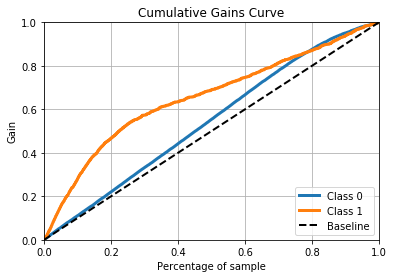

In [90]:
def bestCurve(y):
    defaults = sum(y == 1)
    total = len(y)
    x = np.linspace(0, 1, total)
    y1 = np.linspace(0, 1, defaults)
    y2 = np.ones(total-defaults)
    y3 = np.concatenate([y1,y2])
    return x, y3




# Plotting AUC with gradient descent 

predictions = xtest@beta
y_probas = lrf.sigmoid(predictions)

y_probas = y_probas.flatten()
y_temp = np.zeros((y_probas.shape[0], 2))
y_temp[:,0] = 1-y_probas
y_temp[:,1] = y_probas 
y_probas = y_temp

%matplotlib inline
fig = plt.figure()
skplt.metrics.plot_cumulative_gain(ytest, y_probas)

plt.show()


# Egen logistisk regresjon med stokastisk gradient descent

In [84]:
eta = 0.1 # learning rate
doplot = False
doprint = False
Niteration = 250
batch_size = 3000
batch_size_held_out = nx_train-batch_size

beta = np.random.randn(x.shape[1],1)
costvec=[]
costvec_test=[]
loglvec=[]
xaxis=[]

%matplotlib qt
#plt.axis([0, Niteration, 0, 13])

indexes = np.arange(nx_train)


start = time.time()
for iter in range(Niteration):
    datapoints = np.random.choice(indexes, size=batch_size, replace=False)
    batch_x = xtrain[datapoints,:]
    batch_y = ytrain[datapoints]
    
    batch_x_held_out = np.delete(xtrain, datapoints, axis=0)
    batch_y_held_out = np.delete(ytrain, datapoints).reshape([batch_size_held_out,1])
    
    sig = lrf.sigmoid(batch_x@beta)
    gradient = lrf.gradient_ols(batch_x,batch_y,sig)
    beta -= eta*gradient
    
    #Cost function
    cost = lrf.cost_log_ols(batch_x@beta,batch_y.T)
    cost_test = lrf.cost_log_ols(batch_x_held_out@beta,batch_y_held_out.T)
    #Log Loss function from sklearn
    if doprint:
        logloss=log_loss(batch_y, np.round(batch_x@beta), eps=1e-16, normalize=True)
        print('Cost', cost,'&','Log loss', logloss,'&','Cost test', cost_test)
    if doplot:
        costvec.append(cost.ravel())
        costvec_test.append(cost_test.ravel())
        xaxis.append(iter+1)
        plt.plot(xaxis, costvec, 'b')
        plt.plot(xaxis, costvec_test, 'r')
        plt.pause(1e-12)
plt.show()

end = time.time()
print(end - start)
 

1.7784850597381592


In [85]:
# making confusion matrix to check observed data with model predictions. 

predictions = xtest@beta
sig_val = lrf.sigmoid(predictions)
sig_val = np.round(sig_val)

cm = confusion_matrix(ytest , sig_val.astype(int))
print(cm)



[[3677  996]
 [ 571  756]]


In [58]:
# plotting confusion matrix


skplt.metrics.plot_confusion_matrix(ytrain, predictions, normalize=True)

plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [10618, 6000]

In [86]:
activation =lrf.sigmoid(xtrain@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytrain)/len(activation),'% Training Accuracy')
print(f1_score(ytrain, classes))

activation =lrf.sigmoid(xval@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==yval)/len(activation),'% Validation Accuracy')
print(f1_score(yval, classes))


activation =lrf.sigmoid(xtest@beta) 
classes = np.zeros([len(activation)])
classes=np.round(activation)
print(100*np.sum(classes==ytest)/len(activation),'% Test Accuracy')
print(f1_score(ytest, classes))


66.81107553211528 % Training Accuracy
0.6270110076206605
73.77777777777777 % Validation Accuracy
0.4858835831300105
73.88333333333334 % Test Accuracy
0.49106852874309836


<Figure size 432x288 with 0 Axes>

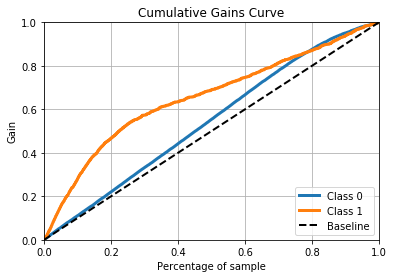

In [91]:
# Plotting AUC with Stocastic gradient descent. 


predictions = xtest@beta
y_probas = lrf.sigmoid(predictions)

y_probas = y_probas.flatten()
y_temp = np.zeros((y_probas.shape[0], 2))
y_temp[:,0] = 1-y_probas
y_temp[:,1] = y_probas 
y_probas = y_temp

fig = plt.figure()
skplt.metrics.plot_cumulative_gain(ytest, y_probas)

plt.show()

In [60]:

model = LogisticRegression()
model.fit(xtrain, ytrain)
predicted_classes = model.predict(xtrain)
accuracy = accuracy_score(ytrain.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_
log_loss(ytrain, predicted_classes)

print(accuracy, '% Training Accuracy')

predicted_classes = model.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),predicted_classes)
accuracy = accuracy * 100
parameters = model.coef_
log_loss(ytest, predicted_classes)

print(accuracy, '% Test Accuracy')

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


70.71953286871351 % Training Accuracy
77.43333333333334 % Test Accuracy


# C) 
Neural Network. 

In [19]:
import NeuralNetwork as nn

neural_net = nn.ANN(lmb=1e-4, bias=0, eta=0.1, mode = 'classification')            
neural_net.add_layers(n_features=[91,50,50,20], n_neurons = [50,50,20,1] , n_layers=4)

x=xtrain
y=ytrain

activation = [lrf.relu, lrf.relu, lrf.sigmoid, lrf.sigmoid]
derivative = [lrf.relu_deriv, lrf.relu_deriv, lrf.sigmoid_deriv, lrf.sigmoid_deriv]

start = time.time()


epochs=200
batch_size=500
neural_net.train(epochs, batch_size, x,y,activation,derivative , verbose=True)

end = time.time()
print(end - start)


Epoch 0 loss [[0.70471968]]
Epoch 1 loss [[0.70340236]]
Epoch 2 loss [[0.70284573]]
Epoch 3 loss [[0.69936161]]
Epoch 4 loss [[0.69968891]]
Epoch 5 loss [[0.69807452]]
Epoch 6 loss [[0.69855161]]
Epoch 7 loss [[0.69674849]]
Epoch 8 loss [[0.69685133]]
Epoch 9 loss [[0.69490785]]
Epoch 10 loss [[0.69285722]]
Epoch 11 loss [[0.69393067]]
Epoch 12 loss [[0.69489337]]
Epoch 13 loss [[0.69261309]]
Epoch 14 loss [[0.69307188]]
Epoch 15 loss [[0.69210297]]
Epoch 16 loss [[0.69225875]]
Epoch 17 loss [[0.69210555]]
Epoch 18 loss [[0.69053875]]
Epoch 19 loss [[0.69152923]]
Epoch 20 loss [[0.69187834]]
Epoch 21 loss [[0.68841358]]
Epoch 22 loss [[0.68863864]]
Epoch 23 loss [[0.69017269]]
Epoch 24 loss [[0.68906488]]
Epoch 25 loss [[0.68920406]]
Epoch 26 loss [[0.68916233]]
Epoch 27 loss [[0.68952622]]
Epoch 28 loss [[0.68934948]]
Epoch 29 loss [[0.68918881]]
Epoch 30 loss [[0.68865309]]
Epoch 31 loss [[0.68965271]]
Epoch 32 loss [[0.68793518]]
Epoch 33 loss [[0.68815222]]
Epoch 34 loss [[0.687574

In [20]:
activ=neural_net.feed_out(x, activation)['3']
print(activ)

classes=np.round(activ)
print(classes)

print(100*np.sum(classes==y)/len(activ),'% Training Accuracy')
#print(f1_score(ytrain, classes)) 

cm = confusion_matrix(y , classes)
print(cm)

[[0.92130395]
 [0.51053861]
 [0.81116876]
 ...
 [0.34380136]
 [0.32824439]
 [0.18566379]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
68.54279686558168 % Training Accuracy
[[5231 1405]
 [2770 3866]]


In [21]:
activ=neural_net.feed_out(xtest, activation)['3']
print(activ)

classes=np.round(activ)
print(classes)

print(100*np.sum(classes==ytest)/len(activ),'% Test Accuracy')
#print(f1_score(ytrain, classes)) 

cm = confusion_matrix(ytest , classes)
print(cm)

[[0.35626146]
 [0.44784336]
 [0.33713856]
 ...
 [0.4081454 ]
 [0.35938217]
 [0.2699401 ]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
74.33333333333333 % Test Accuracy
[[4607 1234]
 [ 691  968]]


In [22]:
cm= confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
print(cm)

[[0 2]
 [1 1]]


In [23]:
from sklearn.neural_network import MLPClassifier


mlp = MLPClassifier(hidden_layer_sizes=(50,50,20,), max_iter=200, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

mlp.fit(x, y.ravel())
print("Training set score: %f" % mlp.score(x, y))
print("Test set score: %f" % mlp.score(xtest, ytest))



Iteration 1, loss = 0.60834948
Iteration 2, loss = 0.57512584
Iteration 3, loss = 0.57085977
Iteration 4, loss = 0.56752559
Iteration 5, loss = 0.56701042
Iteration 6, loss = 0.56355119
Iteration 7, loss = 0.56338919
Iteration 8, loss = 0.56215064
Iteration 9, loss = 0.56181829
Iteration 10, loss = 0.56225884
Iteration 11, loss = 0.55879918
Iteration 12, loss = 0.55862177
Iteration 13, loss = 0.55786457
Iteration 14, loss = 0.55586010
Iteration 15, loss = 0.55459886
Iteration 16, loss = 0.55377945
Iteration 17, loss = 0.55304435
Iteration 18, loss = 0.55318974
Iteration 19, loss = 0.55115862
Iteration 20, loss = 0.55121872
Iteration 21, loss = 0.54828080
Iteration 22, loss = 0.54798109
Iteration 23, loss = 0.54668282
Iteration 24, loss = 0.54711847
Iteration 25, loss = 0.54489824
Iteration 26, loss = 0.54398157
Iteration 27, loss = 0.54392615
Iteration 28, loss = 0.54197553
Iteration 29, loss = 0.54088333
Iteration 30, loss = 0.54039660
Iteration 31, loss = 0.53952060
Iteration 32, los

In [24]:
pred = mlp.predict(x)
accuracy = accuracy_score(y.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)

cm = confusion_matrix(y , pred)
print(cm)

79.6036769138035
[[5602 1034]
 [1673 4963]]


In [25]:
pred = mlp.predict(xtest)
accuracy = accuracy_score(ytest.flatten(),pred)
accuracy = accuracy * 100
print(accuracy)

cm = confusion_matrix(ytest , pred)
print(cm)

74.50666666666666
[[4349 1492]
 [ 420 1239]]
